이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

# 시계열을 위한 딥러닝

## 다양한 종류의 시계열 작업

## 기온 예측 문제

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-03 06:56:25--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.88.190, 52.217.234.152, 16.182.73.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.88.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.9MB/s    in 0.7s    

2023-11-03 06:56:26 (18.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**예나 날씨 데이터셋 조사하기**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 파싱**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**전체 기온을 그래프로 그리기**

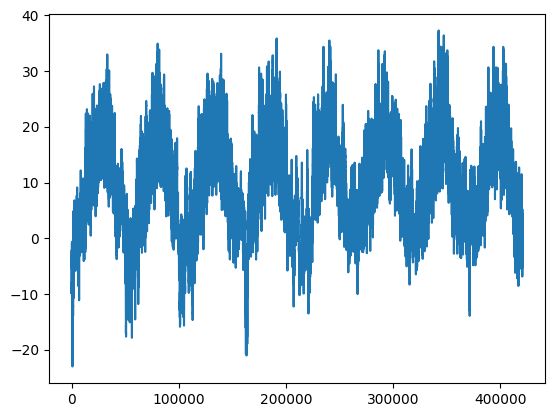

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**처음 10일간의 기온을 그래프로 그리기**

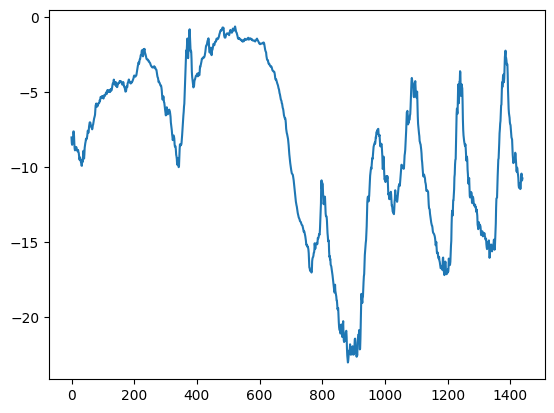

In [5]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**각 분할에 사용할 샘플 수 계산하기**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**훈련, 검증, 테스트 데이터셋 만들기**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**훈련 데이터셋의 배치 크기 확인하기**

In [10]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 상식 수준의 기준점

**상식적인 기준 모델의 MAE 계산하기**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


### 기본적인 머신 러닝 모델 시도해 보기

**밀집 연결 모델 훈련하고 평가하기**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 11.6431 - mae: 2.6472 - val_loss: 11.9873 - val_mae: 2.7567
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 43s 52ms/step - loss: 8.7153 - mae: 2.3233 - val_loss: 10.7710 - val_mae: 2.6029
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 8.0518 - mae: 2.2346 - val_loss: 12.3365 - val_mae: 2.8000
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 7.6995 - mae: 2.1847 - val_loss: 10.6241 - val_mae: 2.5909
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 7.3863 - mae: 2.1393 - val_loss: 10.8965 - val_mae: 2.6158
Epoch 6/10
819/819 [==============================] - 38s 47ms/step - loss: 7.1509 - mae: 2.1041 - val_loss: 10.6415 - val_mae: 2.5882
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 6.9747 - mae: 2.0763 - val_loss: 12.4100 - val_mae: 2.8011
Epoch 8/10
819/819 [==============================] - 48s 59ms/step - loss: 6.8377 - mae: 2.0559 - val_loss: 11.0738 - val_mae: 2.6403
Epoch 9/10
819/819 [==============================] - 47s 57ms/ste

**결과 그래프 그리기**

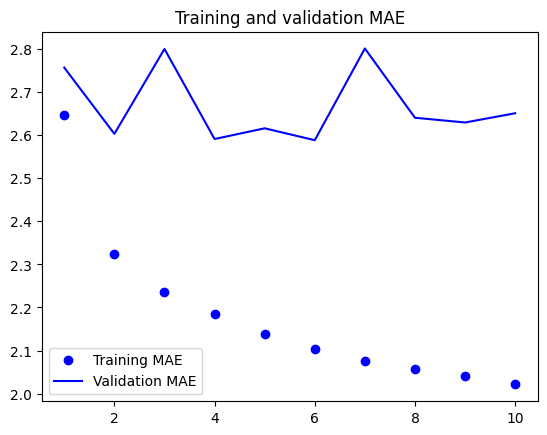

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 모델 시도해 보기

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 48ms/step - loss: 22.2081 - mae: 3.6986 - val_loss: 17.5946 - val_mae: 3.2966
Epoch 2/10
819/819 [==============================] - 41s 49ms/step - loss: 15.9101 - mae: 3.1617 - val_loss: 20.5424 - val_mae: 3.5932
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 14.4073 - mae: 3.0054 - val_loss: 15.4583 - val_mae: 3.0871
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 13.4702 - mae: 2.9036 - val_loss: 14.8965 - val_mae: 3.0534
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 12.7056 - mae: 2.8179 - val_loss: 14.8444 - val_mae: 3.0447
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 12.0952 - mae: 2.7489 - val_loss: 19.9825 - val_mae: 3.5700
Epoch 7/10
819/819 [==============================] - 38s 47ms/step - loss: 11.6504 - mae: 2.6981 - val_loss: 14.6754 - val_mae: 3.0367
Epoch 8/10
819/819 [============================

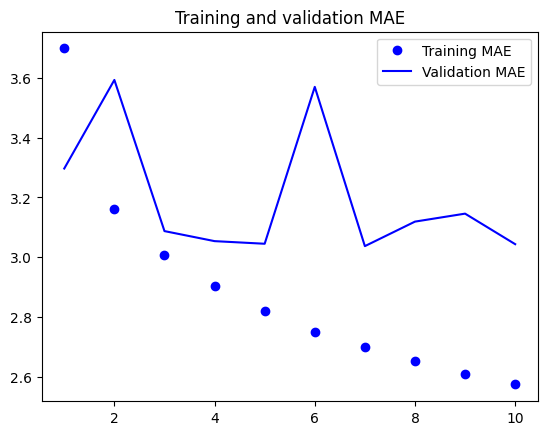

In [16]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 첫 번째 순환 신경망

**간단한 LSTM 기반 모델**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 52ms/step - loss: 48.8885 - mae: 5.1263 - val_loss: 14.2664 - val_mae: 2.8398
Epoch 2/10
819/819 [==============================] - 54s 65ms/step - loss: 11.2802 - mae: 2.6053 - val_loss: 10.2443 - val_mae: 2.4610
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.9043 - mae: 2.4533 - val_loss: 9.6731 - val_mae: 2.4112
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 9.5824 - mae: 2.4103 - val_loss: 9.5505 - val_mae: 2.4027
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 9.2994 - mae: 2.3731 - val_loss: 9.9079 - val_mae: 2.4361
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 9.0046 - mae: 2.3327 - val_loss: 9.6714 - val_mae: 2.4089
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 8.7308 - mae: 2.2986 - val_loss: 9.7696 - val_mae: 2.4314
Epoch 8/10
819/819 [==============================] - 52s 

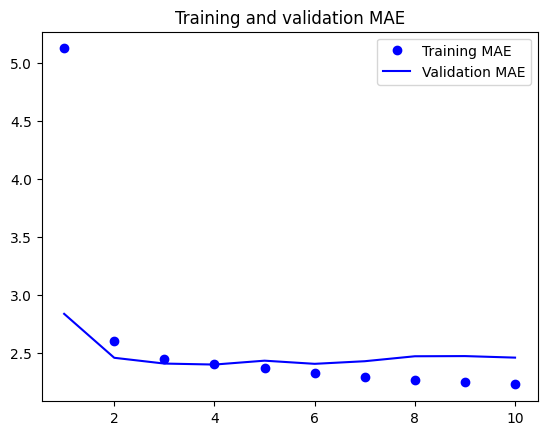

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 순환 신경망 이해하기

**넘파이로 구현한 간단한 RNN**

In [19]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 케라스의 순환 층

**어떤 길이의 시퀀스도 처리할 수 있는 RNN 층**

In [20]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**마지막 출력 스텝만 반환하는 RNN 층**

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**전체 출력 시퀀스를 반환하는 RNN 층**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**스태킹(stacking) RNN 층**

In [23]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 순환 신경망의 고급 사용법

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

**드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 57s 66ms/step - loss: 25.4986 - mae: 3.7522 - val_loss: 9.8706 - val_mae: 2.4336
Epoch 2/50
819/819 [==============================] - 45s 55ms/step - loss: 14.4447 - mae: 2.9416 - val_loss: 9.6151 - val_mae: 2.4041
Epoch 3/50
819/819 [==============================] - 45s 55ms/step - loss: 13.3854 - mae: 2.8292 - val_loss: 9.1080 - val_mae: 2.3482
Epoch 4/50
819/819 [==============================] - 45s 54ms/step - loss: 12.6074 - mae: 2.7476 - val_loss: 9.1785 - val_mae: 2.3614
Epoch 5/50
819/819 [==============================] - 46s 56ms/step - loss: 11.9744 - mae: 2.6818 - val_loss: 9.6602 - val_mae: 2.4325
Epoch 6/50
819/819 [==============================] - 52s 64ms/step - loss: 11.5510 - mae: 2.6302 - val_loss: 9.8566 - val_mae: 2.4397
Epoch 7/50
819/819 [==============================] - 45s 55ms/step - loss: 11.1829 - mae: 2.5894 - val_loss: 9.9830 - val_mae: 2.4565
Epoch 8/50
819/819 [==============================] - 5

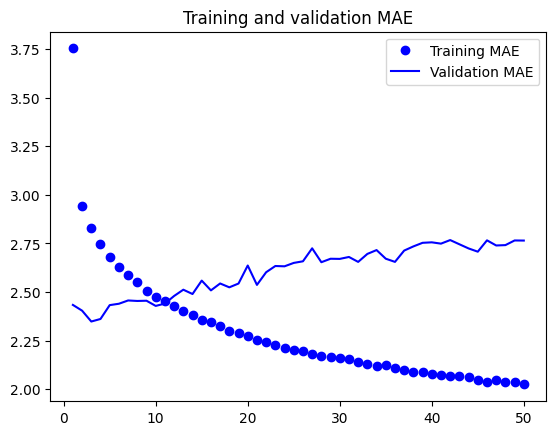

In [25]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [26]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### 스태킹 순환 층

**드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 51s 58ms/step - loss: 22.8440 - mae: 3.5376 - val_loss: 10.0216 - val_mae: 2.4642
Epoch 2/50
819/819 [==============================] - 48s 58ms/step - loss: 13.4467 - mae: 2.8365 - val_loss: 9.1210 - val_mae: 2.3532
Epoch 3/50
819/819 [==============================] - 45s 55ms/step - loss: 12.5574 - mae: 2.7434 - val_loss: 8.7419 - val_mae: 2.2949
Epoch 4/50
819/819 [==============================] - 46s 56ms/step - loss: 11.7473 - mae: 2.6557 - val_loss: 9.0236 - val_mae: 2.3442
Epoch 5/50
819/819 [==============================] - 54s 65ms/step - loss: 11.1289 - mae: 2.5857 - val_loss: 9.2370 - val_mae: 2.3689
Epoch 6/50
819/819 [==============================] - 45s 55ms/step - loss: 10.4581 - mae: 2.5057 - val_loss: 9.5454 - val_mae: 2.4172
Epoch 7/50
819/819 [==============================] - 47s 58ms/step - loss: 9.8363 - mae: 2.4268 - val_loss: 10.0694 - val_mae: 2.4758
Epoch 8/50
819/819 [==============================] - 

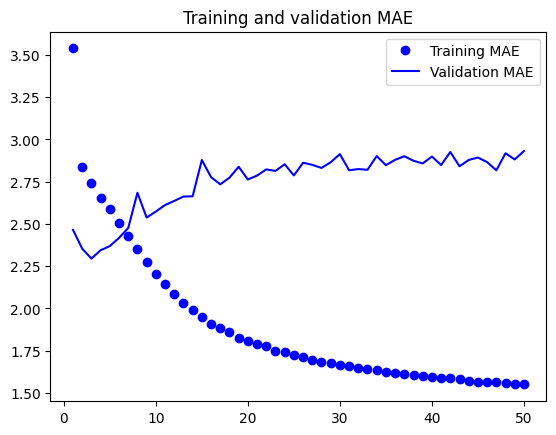

In [28]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 양방향 RNN 사용하기

시퀀스를 거꾸로 뒤집어 LSTM 모델 훈련하기 (책에는 없음)

In [29]:
def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets

train_gen = train_generator()
val_gen = val_generator()

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

Epoch 1/10
819/819 [==============================] - 58s 68ms/step - loss: 34.4427 - mae: 4.4943 - val_loss: 17.2340 - val_mae: 3.2700
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 21.8827 - mae: 3.6623 - val_loss: 16.7471 - val_mae: 3.2083
Epoch 3/10
819/819 [==============================] - 55s 67ms/step - loss: 20.3650 - mae: 3.5217 - val_loss: 16.0861 - val_mae: 3.1253
Epoch 4/10
819/819 [==============================] - 82s 92ms/step - loss: 17.7713 - mae: 3.2862 - val_loss: 13.3988 - val_mae: 2.8408
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 15.6091 - mae: 3.0858 - val_loss: 12.8040 - val_mae: 2.7785
Epoch 6/10
819/819 [==============================] - 115s 140ms/step - loss: 14.6476 - mae: 2.9809 - val_loss: 12.5205 - val_mae: 2.7213
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 13.9296 - mae: 2.9091 - val_loss: 12.2423 - val_mae: 2.6778
Epoch 8/10
819/819 [==========================

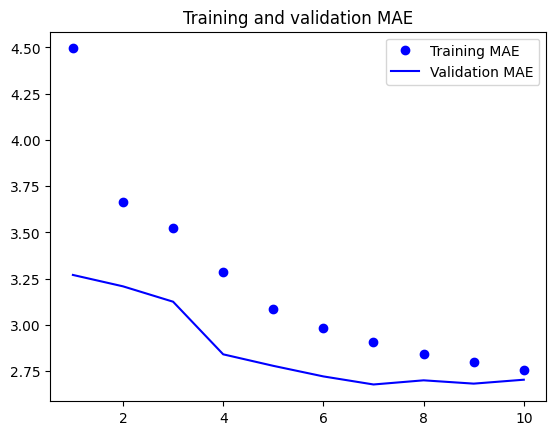

In [31]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**양방향 LSTM 모델 훈련하고 평가하기**

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 55s 62ms/step - loss: 26.2686 - mae: 3.6970 - val_loss: 11.1051 - val_mae: 2.5860
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 9.6917 - mae: 2.4327 - val_loss: 9.7543 - val_mae: 2.4046
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 8.9986 - mae: 2.3375 - val_loss: 9.4536 - val_mae: 2.3768
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 8.4802 - mae: 2.2696 - val_loss: 9.7171 - val_mae: 2.4206
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 8.0960 - mae: 2.2161 - val_loss: 9.4793 - val_mae: 2.3819
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 7.7758 - mae: 2.1717 - val_loss: 9.8579 - val_mae: 2.4301
Epoch 7/10
819/819 [==============================] - 47s 58ms/step - loss: 7.5232 - mae: 2.1358 - val_loss: 9.7900 - val_mae: 2.4127
Epoch 8/10
819/819 [==============================] - 48s 59

### 더 나아가서

## 요약